In [1]:
#
import numpy as np
import os, sys
from glob import glob
from time import time

sys.path.insert(0, '/global/homes/q/qmxp55/DESI/bgstargets/py')

from io_ import get_sweep_whole, getBGSbits, flux_to_mag
from io_ import get_random, get_isdesi, get_dict, bgsmask, get_reg, get_svfields, gaiaAEN
from cuts import getGeoCuts, bgsbut
from QA import getStats, flow, mollweide, mycmap, plot_sysdens, overdensity, hexbin

from QA import set_mwd, get_radec_mw
from io_ import get_isdes

import healpy as hp
import astropy.io.fits as fits
import fitsio
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib
from astropy.coordinates import SkyCoord
import astropy.units as units
from astropy.table import Table

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

# Get stellar catalogue used to compute stellar density PIXWEIGHTS in DESITARGET

In [4]:
gaiadir = '/global/cfs/cdirs/desi/target/gaia_dr2'
hpdir = os.path.join(gaiadir, 'healpix')
catdict = {}

# ADM the number of pixels and the pixel area at nside.
nside = 256
npix = hp.nside2npix(nside)
pixarea = hp.nside2pixarea(nside, degrees=True)

# ADM an output array of all possible HEALPixels at nside.
pixout = np.zeros(npix, dtype='int32')

# ADM find all of the Gaia files.
filenames = glob(os.path.join(hpdir, '*fits'))

# ADM read in each file, restricting to the criteria for point
# ADM sources and storing in a HEALPixel map at resolution nside.
nfiles = len(filenames)

t0 = time()
for nfile, filename in enumerate(filenames):
    if nfile % 1000 == 0 and nfile > 0:
        elapsed = time() - t0
        rate = nfile / elapsed
        print('{}/{} files; {:.1f} files/sec; {:.1f} total mins elapsed'
                 .format(nfile, nfiles, rate, elapsed/60.))

    # ADM save memory, speed up by only reading a subset of columns.
    gobjs = fitsio.read(
        filename,
        columns=['RA', 'DEC', 'PHOT_G_MEAN_MAG', 'ASTROMETRIC_EXCESS_NOISE']
    )
    
    ra, dec = gobjs["RA"], gobjs["DEC"]
    gmag = gobjs["PHOT_G_MEAN_MAG"]
    excess = gobjs["ASTROMETRIC_EXCESS_NOISE"]
    point = (excess == 0.) | (np.log10(excess) < 0.3*gmag-5.3)
    grange = (gmag >= 12) & (gmag < 17)
    w = np.where(point & grange)
    catdict[filename] = gobjs[w]
    

1000/12288 files; 21.0 files/sec; 0.8 total mins elapsed
2000/12288 files; 15.9 files/sec; 2.1 total mins elapsed
3000/12288 files; 14.1 files/sec; 3.5 total mins elapsed
4000/12288 files; 13.6 files/sec; 4.9 total mins elapsed
5000/12288 files; 13.5 files/sec; 6.2 total mins elapsed
6000/12288 files; 13.5 files/sec; 7.4 total mins elapsed
7000/12288 files; 13.3 files/sec; 8.8 total mins elapsed
8000/12288 files; 13.1 files/sec; 10.1 total mins elapsed
9000/12288 files; 13.0 files/sec; 11.5 total mins elapsed
10000/12288 files; 12.9 files/sec; 12.9 total mins elapsed
11000/12288 files; 12.9 files/sec; 14.2 total mins elapsed
12000/12288 files; 12.8 files/sec; 15.6 total mins elapsed


In [5]:
cat = np.concatenate(tuple(catdict.values()))

In [14]:
#
tab = Table()

for col in cat.dtype.names:
    tab[col] = cat[col]
    
hppix = hp.ang2pix(nside,(90.-cat['DEC'])*np.pi/180.,cat['RA']*np.pi/180.,nest=True)
print('healpix DONE...')
c = SkyCoord(cat['RA']*units.degree,cat['DEC']*units.degree, frame='icrs')
tab['b'] = c.galactic.b.value # galb coordinate
tab['l'] = c.galactic.l.value # galb coordinate
print('galactic coordinates DONE...')

regs = ['des', 'decals', 'north', 'desi', 'south']
for i in regs:
    reg_ = get_reg(reg=i, hppix=hppix)
    tab[i] = reg_
    print(i, 'DONE...')

healpix DONE...
galactic coordinates DONE...
des DONE...
decals DONE...
north DONE...
desi DONE...
south DONE...


In [15]:
file_name = '/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/stars/GAIA_12_17_pointsources.npy'
np.save(file_name, tab)

In [17]:
tab

RA,DEC,PHOT_G_MEAN_MAG,ASTROMETRIC_EXCESS_NOISE,b,l,des,decals,north,desi,south
float64,float64,float32,float32,float64,float64,bool,bool,bool,bool,bool
242.1400708259156,38.11023745668459,16.153925,0.27802694,47.58202308046007,60.79286637876266,False,False,True,True,False
242.12295925259235,38.03643797768387,16.264982,0.0,47.59539877610625,60.68341871107556,False,False,True,True,False
241.0391398889119,37.43999572481868,15.877335,0.0,48.45137961895084,59.78923250191836,False,False,True,True,False
240.737633425927,37.14442507130475,16.961843,0.08836903,48.690281802437696,59.34136604095667,False,False,True,True,False
242.0639803453246,37.90358181110342,12.524102,0.0,47.64151446561641,60.48612549054165,False,False,True,True,False
242.28044256369023,38.20809669371975,16.023594,0.0,47.471697660528186,60.937871569438194,False,False,True,True,False
242.26430076027634,38.187867288354305,14.143254,0.0,47.48437455419978,60.90793280040001,False,False,True,True,False
241.72924518302605,37.533676550095066,14.904157,0.0,47.90422811324111,59.933535824319314,False,False,True,True,False
241.0732093678067,37.45233271330522,16.726553,0.0,48.424355517790325,59.807909001281125,False,False,True,True,False


# Get stellar catalogue used to mask around BRIGHT STARS

In [26]:
df3 = fitsio.read('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/stars/gaia-mask-dr9-both.fits.gz')

In [ ]:
['ra', 'dec', 'ref_cat', 'mag', 'mask_mag', 'radius', 'radius_pix', 'in_desi', 'istycho', 'isgaia', 
 'pointsource', 'decam_mag_g', 'decam_mag_r', 'decam_mag_z', 'zguess', 'gaia_phot_g_mean_mag']

'isbright',
'ismedium',

In [29]:
#
tab = Table()
mask = df3['isbright']
cat = df3[mask]
cols = ['ra', 'dec', 'ref_cat', 'mag', 'mask_mag', 'radius', 'radius_pix', 'in_desi', 
        'istycho', 'isgaia', 'pointsource', 'decam_mag_g', 'decam_mag_r', 'decam_mag_z', 
        'zguess', 'gaia_phot_g_mean_mag']

for col in cols:
    tab[col.upper()] = cat[col]
    
hppix = hp.ang2pix(nside,(90.-cat['dec'])*np.pi/180.,cat['ra']*np.pi/180.,nest=True)
print('healpix DONE...')
c = SkyCoord(cat['ra']*units.degree,cat['dec']*units.degree, frame='icrs')
tab['b'] = c.galactic.b.value # galb coordinate
tab['l'] = c.galactic.l.value # galb coordinate
print('galactic coordinates DONE...')

regs = ['des', 'decals', 'north', 'desi', 'south']
for i in regs:
    reg_ = get_reg(reg=i, hppix=hppix)
    tab[i] = reg_
    print(i, 'DONE...')
    
file_name = '/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/stars/bright_stars.npy'
np.save(file_name, tab)

healpix DONE...
galactic coordinates DONE...
des DONE...
decals DONE...
north DONE...
desi DONE...
south DONE...


In [31]:
#
tab = Table()
mask = df3['ismedium']
cat = df3[mask]
cols = ['ra', 'dec', 'ref_cat', 'mag', 'mask_mag', 'radius', 'radius_pix', 'in_desi', 
        'istycho', 'isgaia', 'pointsource', 'decam_mag_g', 'decam_mag_r', 'decam_mag_z', 
        'zguess', 'gaia_phot_g_mean_mag']

for col in cols:
    tab[col.upper()] = cat[col]
    
hppix = hp.ang2pix(nside,(90.-cat['dec'])*np.pi/180.,cat['ra']*np.pi/180.,nest=True)
print('healpix DONE...')
c = SkyCoord(cat['ra']*units.degree,cat['dec']*units.degree, frame='icrs')
tab['b'] = c.galactic.b.value # galb coordinate
tab['l'] = c.galactic.l.value # galb coordinate
print('galactic coordinates DONE...')

regs = ['des', 'decals', 'north', 'desi', 'south']
for i in regs:
    reg_ = get_reg(reg=i, hppix=hppix)
    tab[i] = reg_
    print(i, 'DONE...')
    
file_name = '/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/stars/medium_bright_stars.npy'
np.save(file_name, tab)

healpix DONE...
galactic coordinates DONE...
des DONE...
decals DONE...
north DONE...
desi DONE...
south DONE...


In [42]:
df = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/stars/medium_bright_stars.npy')

In [43]:
print(df.shape)
print(df.dtype.names)

(13656327,)
('RA', 'DEC', 'REF_CAT', 'MAG', 'MASK_MAG', 'RADIUS', 'RADIUS_PIX', 'IN_DESI', 'ISTYCHO', 'ISGAIA', 'POINTSOURCE', 'DECAM_MAG_G', 'DECAM_MAG_R', 'DECAM_MAG_Z', 'ZGUESS', 'GAIA_PHOT_G_MEAN_MAG', 'b', 'l', 'des', 'decals', 'north', 'desi', 'south')


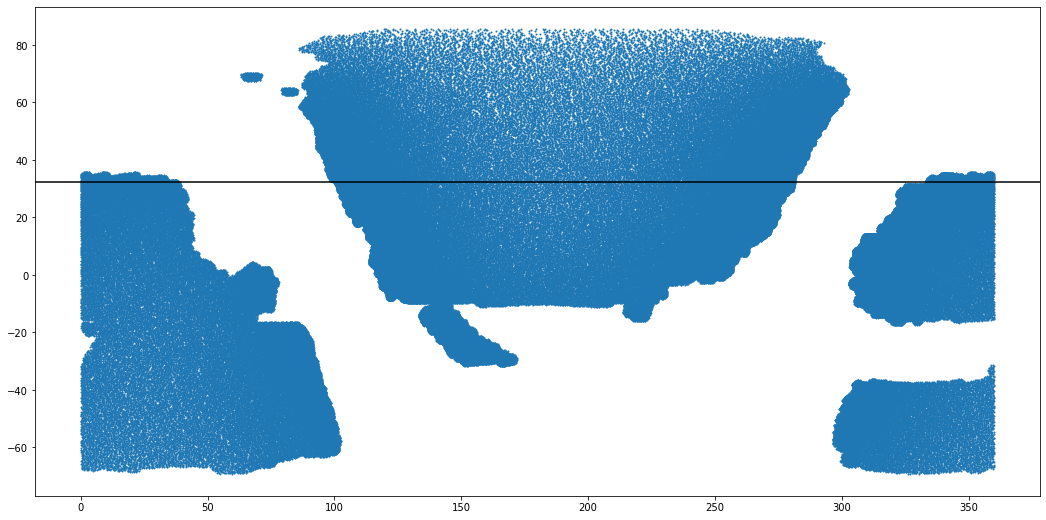

In [44]:
plt.figure(figsize=(18,9))
plt.scatter(df['RA'][::50], df['DEC'][::50], s=1)
plt.axhline(32.375, color='k')
plt.show()